# T7 - Calibration

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/tut_calibration.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Ftut_calibration.ipynb).
    
</div>

### Introduction

Disease models typically require contextualization to a relevant setting of interest prior to addressing "what-if" scenario questions. The process of tuning model input parameters so that model outputs match observed data is known as calibration. There are many approaches to model calibration, ranging from manual tuning to fully Bayesian methods.

For many applications, we have found that an optimization-based approach is sufficient. Such methods avoid the tedious process of manual tuning and are less computationally expensive than fully Bayesian methods. One such optimization-based approach is the Optuna library, which is a Bayesian hyperparameter optimization framework. Optuna is designed for tuning hyperparameters of machine learning models, but it can also be used to calibrate disease models.

Calibration libraries often treat the disease model as a black box, where the input parameters are the "hyperparameters" to be tuned. The calibration process is often iterative and requires a combination of expert knowledge and computational tools. The optimization algorithm iteratively chooses new parameter values to evaluate, and the model is run with these values to generate outputs. The outputs are compared to observed data, and a loss function is calculated to quantify the difference between the model outputs and the observed data. The optimization algorithm then uses this loss function to update its search strategy and choose new parameter values to evaluate. This process continues until the algorithm converges to a set of parameter values that minimize the loss function.

While many optimization algorithms are available, Starsim has a built-in interface to the Optuna library, which we will demonstrate in this tutorial. We will use a simple Susceptible-Infected-Recovered (SIR) model as an example. We will tune three input parameters, the infectivity parameter, `beta`, the initial prevalence parameter, `init_prev`, and the Poisson-distributed degree distribution parameter, `n_contacts`. We will calibrate the model using a beta-binomial likelihood function so as to match prevalence at three distinct time points.

We begin with a few imports and default settings:

In [1]:
#%% Imports and settings
import sciris as sc
import starsim as ss
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

n_agents = 2e3
debug = False # If true, calibration will run in serial instead of parallel

/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The calibration class will require a base `Sim` object. This `sim` will later be modified according to parameters selected by the optimization engine. The following function creates the base `Sim` object.

In [2]:
def make_sim():
    sir = ss.SIR(
        beta = ss.beta(0.075),
        init_prev = ss.bernoulli(0.02),
    )
    random = ss.RandomNet(n_contacts=ss.poisson(4))

    sim = ss.Sim(
        n_agents = n_agents,
        start = sc.date('2020-01-01'),
        stop = sc.date('2020-02-12'),
        dt = 1,
        unit = 'day',
        diseases = sir,
        networks = random,
        verbose = 0,
    )

    return sim

Now let's define the calibration parameters. These are the inputs that Optuna will be able to modify. Here, we define three such parameters, `beta`, `init_prev`, and `n_contacts`.

Each parameter entry should have range defined by `low` and `high` as well as a `guess` values. The `guess` value is not used by Optuna, rather only for a check after calibration completes to see if the new parameters are better than the `guess` values.

You'll notice there are a few other parameters that can be specified. For example, the data type of the parameter appears in `suggest_type`. Possible values are listed in the Optuna documentation, and include [suggest_float](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) for float values and [suggest_int](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) for integer types.

To make things easier for the search algorithm, it's helpful to indicate how outputs are expected to change with inputs. For example, increasing `beta` from 0.01 to 0.02 should double disease transmission, but increasing from 0.11 to 0.12 will have a small effect. Thus, we indicate that this parameter should be calibrated with `log=True`.

In [3]:
# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True), # Note the log scale
    init_prev = dict(low=0.01, high=0.05, guess=0.15), # Default type is suggest_float, no need to re-specify
    n_contacts = dict(low=2, high=10, guess=3, suggest_type='suggest_int'), # Suggest int just for this demo
)

The optimization engine iteratively chooses input parameters to simulate. Those parameters are passed into the following `build_sim` function as a dictionary of `calib_pars` along with the base `sim` and any other key word arguments. The `calib_pars` will be as above, but importantly will have an additional key named `value` containing the value selected by Optuna.

<div class="alert alert-danger" role="alert">
When modifying a sim, it is important to realize that the simulation has not been initialized yet. Nonetheless, the configuration is available for modification at sim.pars, as demonstrated in the function below.
</div>

In [4]:
def build_sim(sim, calib_pars, n_reps=1, **kwargs):
    """
    Modify the base simulation by applying calib_pars. The result can be a
    single simulation or multiple simulations if n_reps>1. Note that here we are
    simply building the simulation by modifying the base sim. Running the sims
    and extracting results will be done by the calibration function.
    """

    # Because the sim is not initialized, sim.pars contains exactly what we
    # passed into ss.Sim when creating the sim (above). We set diseases=sir and
    # networks=random, where sir is an instance of the SIR class and random is
    # an instance of the RandomNet network.
    sir = sim.pars.diseases # There is only one disease in this simulation and it is a SIR
    net = sim.pars.networks # There is only one network in this simulation and it is a RandomNet

    for k, pars in calib_pars.items(): # Loop over the calibration parameters
        if k == 'rand_seed':
            sim.pars.rand_seed = v
            continue

        # Each item in calib_pars is a dictionary with keys like 'low', 'high',
        # 'guess', 'suggest_type', and importantly 'value'. The 'value' key is
        # the one we want to use as that's the one selected by the algorithm.
        v = pars['value']
        if k == 'beta':
            sir.pars.beta = ss.rate_prob(v)
        elif k == 'init_prev':
            sir.pars.init_prev = ss.bernoulli(v)
        elif k == 'n_contacts':
            net.pars.n_contacts = ss.poisson(v)
        else:
            raise NotImplementedError(f'Parameter {k} not recognized')

    # If just one simulation per parameter set, return the single simulation
    if n_reps == 1:
        return sim

    # But if you'd like to run multiple simulations with the same parameters, we return a MultiSim instead.
    # Note that each simulation will have a different random seed, you can set specific seeds if you like.
    # Also note that parallel=False and debug=True are important to avoid issues with parallelism in the calibration.
    # Advanced: If running multiple reps, you can choose if/how they are combined using the "combine_reps" argument to each CalibComponent, described below.
    if 'rand_seed' in calib_pars:
        base_seed = calib_pars['rand_seed']
    else:
        base_seed = np.random.randint(0, 1e6)
    ms = ss.MultiSim(sim, iterpars=dict(rand_seed=np.arange(base_seed, base_seed+n_reps)), initialize=True, debug=True, parallel=False)
    return ms

## Using the Calibration class
The Starsim framework has been integrated with the Optuna hyperparameter optimization algorithm to facilitate calibration through the `Calibration` class. Recall that an optimization-based approach to calibration minimizes a function of the input parameters. This function is key to achieving an acceptable calibration.

There are two ways to describe the goodness-of-fit function for the `Calibration`. The first method is to directly provide a function that the algorithm will call. The `eval_fn` will be passed each completed `sim` after running, and is expected to return a float representing the **mismatch (lower is better as the optimization algorithm is configured to minimize)**. Data can be passed into the `eval_fn` via `eval_kwargs`.

### Calibration Components
As an alternative to directly specifying the evaluation function, you can use `CalibComponent`s. Each component includes real data, for example from a survey, that is compared against simulation data from the model. Several components can be used at the same time, for example one for disease prevalence and another for treatment coverage. Each component computes a likelihood of the data given the input parameters, as assessed via simulation. Components are combined assuming independence.

The base class for a component is called `CalibComponent`, which you can use to define your own likelihood. However, we have provided components for several key likelihood functions as described below. Each component takes in a `name` and a `weight`, which is used when combining log likelihoods.

### Expected (observed) data
Importantly, each component takes in the calibration target, the real data that was observed, in an argument called `expected`. This argument should be a Pandas Dataframe with one row per time point and columns that will depend on the specific component type. For example, the `Binomial` component requires columns of `n` (trials) and `x` (successes).

### Extracting (actual) simulation data
The components also handle extracting data from each simulation using the `extract_fn` argument. The value of this argument should be a function that takes in a simulation and returns a Pandas DataFrame. The specifics of the columns will depend a bit on the type of component (e.g. `BetaBinomial` is different from `Normal`), but often looks like a simulated version of `expected`. We will see examples below.

### Conforming
We'll also see how to use the `conform` argument, the purpose of which is to align the simulation output to the time points at which the data were observed. The extract_fn should return simulation output in a DataFrame with a time index containing the full time course of the simulation. The conformer will take that output and align it to the time points in the `expected` DataFrame. The built-in conformers are as follows:
* **step_containing:** Conform by simply choosing the simulated timestep that contains the time indicated in the real data (`expected`)
* **prevalent:** Interpolate the simulated timepoints to estimate the values that would have occurred at each real timepoint
* **incident:** While the two methods above capture the state of the model at a particular point in time (stocks), this component allows you to capture the behavior of the model over time (flows). Instead of just giving one time value, `t`, you'll provide a second time value as well called `t1`. This conformer will add up events occurring between the two time points.

You can also create your own conformer simply by passing a callable function instead of one of the above strings. The function should take two arguments, expected (the real-world data) and actual (extracted from the simulation) and should return a Pandas DataFrame that looks like expected.

### Components
Here is a detailed description of each component type, the required columns, and a code example:

* **BetaBinomial**

    This likelihood component is useful for modeling count data. From the simulation, we estimate a Beta distribution representing a probability like the prevalence. This Beta distribution is estimated from the simulated number of successes (e.g. infections) in the simulated number of trials (e.g. population size). Then, we compute the probability of seeing the real data from a Binomial model in which the probability parameter `p` is drawn from the Beta distribution we estimated from the simulation. This Binomial step uses the observed number of trials (e.g. real population size).

    Required columns in expected (real data) and extracted (simulation data) DataFrames are `n` (trials) and `x` (successes). The time index should be named `t` in both DataFrames. If using the `incident` conformer, the index of the expected DataFrame should have a second column named `t1` that indicates the end of the time period over which to sum the simulation data.

    ```python
    component = ss.BetaBinomial(
        name = "Example Beta Binomial",

        # "prevalent" in this example means that we want to interpolate simulation
        # data to obtain estimates at the time points of the expected data
        conform = 'prevalent',

        # Note that expected and extracted dataframes have "n" and "x" columns
        expected = pd.DataFrame({
            'x': [10, 20, 30]     # Number of positive tests
            'n': [100, 200, 300], # Number of people tested
        }, index=pd.Index([ss.date(d) for d in ['2020-01-12', '2020-01-25', '2020-02-02']], name='t')), # On these dates

        extract_fn = lambda sim: pd.DataFrame({ # Function to extract data from the simulation
            'x': sim.results.sir.n_infected,
            'n': sim.results.n_alive,
        }, index = pd.Index(sim.results.timevec, name='t')), # Note sim results are for all time steps

        weight = 1.0,
    )
    ```

* **Binomial**

    Similar to the BetaBinomial, except the Beta distribution is not used. Instead, the `p` parameter used in the Binomial is simply $p=x/n$, where `x` is the number of successes and `n` is the number of trials. To avoid dividing by zero, you can add +1 to `x` and +2 to `n` as is done with a Jeffreys prior.

    Required columns in the `expected` DataFrame are `n` (trials) and `x` (successes), exactly as in the `BetaBinomial` above.

* **DirichletMultinomial**

    Used for modeling count data with multiple categories. This is useful for modeling data such as the distribution over outcomes, like cases by day of week or month of year. This component uses a Dirichlet distribution to model the probabilities of each category, and then uses a Multinomial distribution to model the counts in each category. The Dirichlet distribution is estimated from the simulated counts to estimate a probability distribution over the categories, and the Multinomial distribution is used to compute the probability of seeing the real data given the estimated probabilities. The Dirichlet-Multinomial is like a Beta-Binomial, but for multiple categories.

    Required columns are 'x1', 'x2', ..., 'xn' in the expected (real data) and extracted (simulation data) DataFrames. The time index should be named `t` in both DataFrames. If using the `incident` conformer, the index of the expected DataFrame should have a second column named `t1` that indicates the end of the time period over which to sum the simulation data.

    ```python
    component = ss.DirichletMultinomial(
        name = "Example Dirichlet Multinomial",

        # "step_containing" in this example indicates that we want to choose the
        # simulation time step that contains the time points of the expected data
        conform = 'step_containing',

        # Note that expected and extracted dataframes columns named "x1", "x2", ..., "xn"
        expected = pd.DataFrame({
            'x1': [72, 144], # Number observed in group 1, e.g. quarter 1 of the year
            'x2': [12, 23]   # Number observed in group 2, e.g. quarter 2 of the year
            'x3': [55, 47]   # Number observed in group 3, e.g. quarter 3 of the year
            'x4': [5, 3]     # Number observed in group 4, e.g. quarter 4 of the year
        }, index=pd.Index([ss.date(d) for d in ['2018-06-01', '2019-06-01']], name='t')), # On these dates

        extract_fn = lambda sim: pd.DataFrame({ # Function to extract data from the simulation
            'x1': sim.results.new_infections_Q1,
            'x2': sim.results.new_infections_Q2,
            'x3': sim.results.new_infections_Q3,
            'x4': sim.results.new_infections_Q4,
        }, index = pd.Index(sim.results.timevec, name='t')), # Note sim results are for all time steps

        weight = 1.0,
    )
    ```

* **GammaPoisson**

    Often used for modeling data that comes from a Poisson counting process. This component uses a Gamma distribution to model the rate parameter of the Poisson distribution, and then uses the Poisson distribution to model the counts. The Gamma distribution is estimated from the simulated counts, and the Poisson distribution is used to compute the probability of seeing the real data given the estimated rate parameter. This component is often used with the `incident` conformer, which allows you to model the counts over a time period rather than at a single time point.

    Required columns in expected (real data) and extracted (simulation data) DataFrames are `n` (events) and `x` (person years). The time index should be named `t` in both DataFrames. If using the `incident` conformer, the index of the expected DataFrame should have a second column named `t1` that indicates the end of the time period over which to sum the simulation data.

    ```python
    component = ss.GammaPoisson(
        name = "Example Gamma Poisson",

        # "incident" in this example means that we want to sum up simulation data
        # between "t" and "t1". This is accomplished by interpolating the
        # simulation value at "t" and "t1" and then taking the difference.
        conform = 'incident',

        # Note that expected and extracted dataframes have "n" and "x" columns
        expected = pd.DataFrame({
            'x':  [  15,   34,   22]  # Number of events between t and t1
            'n':  [5400, 4800, 3200], # Number of person years at risk
            't':  [ss.date(d) for d in ['2010-01-01', '2015-01-01', '2020-01-01']], # Start dates
            't1': [ss.date(d) for d in ['2010-12-31', '2015-12-31', '2020-12-31']], # End dates
        }).set_index(['t', 't1']),

        extract_fn = lambda sim: pd.DataFrame({ # Function to extract data from the simulation
            'x': sim.results.sir.new_infections,            # Number of new infections
            'n': sim.results.n_susceptible * sim.t.dt_year, # Person years at risk
        }, index = pd.Index(sim.results.timevec, name='t')), # Note sim results are for all time steps, do not add t1

        weight = 2.0, # If this component is important, increase the weight
    )
    ```

* **Normal**

    A Gaussian likelihood function, used for modeling continuous data but also compatible with large numbers of count data. The mean is the result from each simulation and the variance can be specified by the user or selected automatically so as to maximize likelihood. This component is equivalent to the traditional squared error loss function provided the variance is fixed.

    The only required column in the expected (real data) DataFrame is `x`, which is the observed value. However, if you also provide a column named `n`, the component will use the ratio $x/n$ as the mean of the normal distribution. The time index should be named `t` in both DataFrames. If using the `incident` conformer, the index of the expected DataFrame should have a second column named `t1` that indicates the end of the time period over which to sum the simulation data.

    ```python
    component = ss.Normal(
        name = "Example Normal",

        # "prevalent" in this example means that we want to interpolate simulation
        # data to obtain estimates at the time points of the expected data
        conform = 'prevalent',

        # Note that expected and extracted dataframes have "n" and "x" columns
        expected = pd.DataFrame({
            'x': [0.20, 0.21, 0.17] # Observed values
        }, index=pd.Index([ss.date(d) for d in ['2002-01-21', '2004-07-15', '2007-03-24']], name='t')), # On these dates

        extract_fn = lambda sim: pd.DataFrame({ # Function to extract data from the simulation
            'x': sim.results.sir.n_infected,
            'n': sim.results.n_alive,
        }, index = pd.Index(sim.results.timevec, name='t')), # Note sim results are for all time steps

        # Giving a weight of zero means this component will not affect the loss
        # function, but output plots will still be generated if you just want to
        # see the results
        weight = 0.0,
    )
    ```

## Continuing the calibration example

Let's make a BetaBinomial component, as might be used to calibrate disease prevalence.

In [5]:
prevalence = ss.BetaBinomial(
    name = 'Disease prevalence',
    conform = 'prevalent',

    expected = pd.DataFrame({
        'x': [13, 16, 6],    # Expected number of infections
        'n': [98, 108, 104], # Total number of tests
    }, index=pd.Index([ss.date(d) for d in ['2020-01-12', '2020-01-25', '2020-02-02']], name='t')), # On these dates
    
    extract_fn = lambda sim: pd.DataFrame({
        'x': sim.results.sir.n_infected,
        'n': sim.results.n_alive,
    }, index=pd.Index(sim.results.timevec, name='t')),

    weight = 1.0,
)

Finally, we can bring all the pieces together. We make a single base simulation and create an instance of a Starsim Calibration object. This object requires a few arguments, like the `calib_pars` and `sim`. We also pass in the function that modifies the base `sim`, here our `build_sim` function. No additional `build_kw` are required in this example.

The list of calibration `components` is also provided to the Calibration. Note that instead of using this "component-based" system, a user could simply provide an `eval_fn`, which takes in a completed sim an any `eval_kwargs` and returns a "mismatch" score to be minimized - this feature is demonstrated at the end of this notebook.

The configuration also specifies the total number of trials to run, the number of parallel works, and a few other parameters.

In [6]:
sc.heading('Beginning calibration')

# Make the base sim onto which the calibration parameters will be applied
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=3), # Run 3 replicates for each parameter set
    reseed = True, # If true, a different random seed will be provided to each configuration
    components = [prevalence],
    total_trials = 100,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug, # Run in serial if True
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate();



—————————————————————
Beginning calibration
—————————————————————


Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db


[I 2025-04-04 10:35:40,415] A new study created in RDB with name: starsim_calibration


Elapsed time: 0.318 s
Elapsed time: 0.329 s
Elapsed time: 0.331 s
Elapsed time: 0.351 s


[I 2025-04-04 10:35:41,423] Trial 0 finished with value: 33.388862382852864 and parameters: {'beta': 0.01722716329084701, 'init_prev': 0.010581447888458948, 'n_contacts': 4, 'rand_seed': 88966}. Best is trial 3 with value: 17.07988047465132.
[I 2025-04-04 10:35:41,422] Trial 3 finished with value: 17.07988047465132 and parameters: {'beta': 0.25798352756905024, 'init_prev': 0.027391047566679406, 'n_contacts': 2, 'rand_seed': 773125}. Best is trial 3 with value: 17.07988047465132.


Elapsed time: 0.361 s

[I 2025-04-04 10:35:41,425] Trial 1 finished with value: 29.998549176479337 and parameters: {'beta': 0.03576070881553149, 'init_prev': 0.011647954763285435, 'n_contacts': 3, 'rand_seed': 425151}. Best is trial 3 with value: 17.07988047465132.



Elapsed time: 0.373 s


[I 2025-04-04 10:35:41,443] Trial 2 finished with value: 24.103815065908904 and parameters: {'beta': 0.2803775637701864, 'init_prev': 0.029467414878725565, 'n_contacts': 8, 'rand_seed': 660828}. Best is trial 3 with value: 17.07988047465132.


Elapsed time: 0.393 s
Elapsed time: 0.397 sElapsed time: 0.398 s

Elapsed time: 0.404 s


[I 2025-04-04 10:35:41,468] Trial 9 finished with value: 28.662424286356597 and parameters: {'beta': 0.014264849792946666, 'init_prev': 0.0250525200395173, 'n_contacts': 6, 'rand_seed': 86819}. Best is trial 3 with value: 17.07988047465132.
[I 2025-04-04 10:35:41,468] Trial 4 finished with value: 18.187511759890857 and parameters: {'beta': 0.031094001772170175, 'init_prev': 0.0258026245159666, 'n_contacts': 5, 'rand_seed': 9737}. Best is trial 3 with value: 17.07988047465132.
[I 2025-04-04 10:35:41,494] Trial 5 finished with value: 5.22977945889221 and parameters: {'beta': 0.02532847407417317, 'init_prev': 0.027861033025216295, 'n_contacts': 8, 'rand_seed': 728159}. Best is trial 5 with value: 5.22977945889221.
[I 2025-04-04 10:35:41,502] Trial 6 finished with value: 25.554041130543077 and parameters: {'beta': 0.07378248691823285, 'init_prev': 0.042435892109489615, 'n_contacts': 7, 'rand_seed': 660438}. Best is trial 5 with value: 5.22977945889221.
[I 2025-04-04 10:35:41,512] Trial 8 f

Elapsed time: 0.237 s
Elapsed time: 0.234 sElapsed time: 0.245 s

[I 2025-04-04 10:35:41,778] Trial 11 finished with value: 31.536454744359983 and parameters: {'beta': 0.021026892664918372, 'init_prev': 0.043222199883130356, 'n_contacts': 2, 'rand_seed': 407094}. Best is trial 5 with value: 5.22977945889221.


[I 2025-04-04 10:35:41,800] Trial 12 finished with value: 14.27745693574338 and parameters: {'beta': 0.21644572235812565, 'init_prev': 0.047330377553529444, 'n_contacts': 2, 'rand_seed': 134019}. Best is trial 5 with value: 5.22977945889221.
[I 2025-04-04 10:35:41,820] Trial 13 finished with value: 34.09084006316967 and parameters: {'beta': 0.012726253158409816, 'init_prev': 0.01662568486888035, 'n_contacts': 3, 'rand_seed': 73946}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.276 s
Elapsed time: 0.261 s


[I 2025-04-04 10:35:41,875] Trial 16 finished with value: 8.517695230097015 and parameters: {'beta': 0.09666131413534178, 'init_prev': 0.02877663918523008, 'n_contacts': 2, 'rand_seed': 628203}. Best is trial 5 with value: 5.22977945889221.
[I 2025-04-04 10:35:41,882] Trial 14 finished with value: 24.995752853309106 and parameters: {'beta': 0.18770772127708202, 'init_prev': 0.0266896353203053, 'n_contacts': 7, 'rand_seed': 737018}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.336 s
Elapsed time: 0.318 s
Elapsed time: 0.306 s


[I 2025-04-04 10:35:41,958] Trial 15 finished with value: 20.180238016561983 and parameters: {'beta': 0.014888382139080995, 'init_prev': 0.01384179589019436, 'n_contacts': 9, 'rand_seed': 378426}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.302 s

[I 2025-04-04 10:35:41,964] Trial 18 finished with value: 27.456819486450478 and parameters: {'beta': 0.010849572550523871, 'init_prev': 0.04791091718088532, 'n_contacts': 7, 'rand_seed': 979042}. Best is trial 5 with value: 5.22977945889221.
[I 2025-04-04 10:35:41,966] Trial 17 finished with value: 26.998592684100352 and parameters: {'beta': 0.13305506049513807, 'init_prev': 0.019655498092860223, 'n_contacts': 10, 'rand_seed': 60436}. Best is trial 5 with value: 5.22977945889221.


[I 2025-04-04 10:35:41,996] Trial 19 finished with value: 22.64445238156981 and parameters: {'beta': 0.06910682711169502, 'init_prev': 0.0473955824634855, 'n_contacts': 7, 'rand_seed': 879550}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.309 s


[I 2025-04-04 10:35:42,044] Trial 10 finished with value: 23.41154165201002 and parameters: {'beta': 0.17938327132918921, 'init_prev': 0.04402469076649695, 'n_contacts': 7, 'rand_seed': 830901}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.305 s
Elapsed time: 0.287 s


[I 2025-04-04 10:35:42,188] Trial 20 finished with value: 23.437830722767856 and parameters: {'beta': 0.07187862384692946, 'init_prev': 0.049444248455226436, 'n_contacts': 7, 'rand_seed': 975122}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.289 s

[I 2025-04-04 10:35:42,203] Trial 21 finished with value: 27.20263784982818 and parameters: {'beta': 0.0773949307207416, 'init_prev': 0.04953017512271969, 'n_contacts': 7, 'rand_seed': 944175}. Best is trial 5 with value: 5.22977945889221.


[I 2025-04-04 10:35:42,237] Trial 22 finished with value: 24.73237177006381 and parameters: {'beta': 0.07385415707333981, 'init_prev': 0.035978876600225064, 'n_contacts': 7, 'rand_seed': 940629}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.280 s
Elapsed time: 0.313 s


[I 2025-04-04 10:35:42,287] Trial 24 finished with value: 16.57216504778641 and parameters: {'beta': 0.09462457997341876, 'init_prev': 0.03494964845751105, 'n_contacts': 5, 'rand_seed': 919128}. Best is trial 5 with value: 5.22977945889221.
[I 2025-04-04 10:35:42,288] Trial 23 finished with value: 6.590244898722978 and parameters: {'beta': 0.07019813092495011, 'init_prev': 0.03544142192254042, 'n_contacts': 5, 'rand_seed': 986850}. Best is trial 5 with value: 5.22977945889221.


Elapsed time: 0.310 s
Elapsed time: 0.285 sElapsed time: 0.302 s

[I 2025-04-04 10:35:42,371] Trial 25 finished with value: 6.396111602958267 and parameters: {'beta': 0.07021901194094346, 'init_prev': 0.0339148001786713, 'n_contacts': 5, 'rand_seed': 897676}. Best is trial 5 with value: 5.22977945889221.


[I 2025-04-04 10:35:42,393] Trial 26 finished with value: 4.391245059015034 and parameters: {'beta': 0.06582142629861196, 'init_prev': 0.03625917079424408, 'n_contacts': 5, 'rand_seed': 896143}. Best is trial 28 with value: 3.486621500496407.
[I 2025-04-04 10:35:42,393] Trial 28 finished with value: 3.486621500496407 and parameters: {'beta': 0.04750649537601375, 'init_prev': 0.03363182362878376, 'n_contacts': 5, 'rand_seed': 542740}. Best is trial 28 with value: 3.486621500496407.


Elapsed time: 0.299 s
Elapsed time: 0.296 s

[I 2025-04-04 10:35:42,432] Trial 27 finished with value: 5.353216423455042 and parameters: {'beta': 0.06864039603889474, 'init_prev': 0.03465825495262883, 'n_contacts': 5, 'rand_seed': 898142}. Best is trial 28 with value: 3.486621500496407.


[I 2025-04-04 10:35:42,477] Trial 29 finished with value: 4.645974535884755 and parameters: {'beta': 0.041933952038825745, 'init_prev': 0.03230417122629931, 'n_contacts': 5, 'rand_seed': 552299}. Best is trial 28 with value: 3.486621500496407.


Elapsed time: 0.525 s


[I 2025-04-04 10:35:42,824] Trial 30 finished with value: 10.39991730094947 and parameters: {'beta': 0.043853582479246624, 'init_prev': 0.03564590891341789, 'n_contacts': 4, 'rand_seed': 569437}. Best is trial 28 with value: 3.486621500496407.


Elapsed time: 0.532 s


[I 2025-04-04 10:35:42,861] Trial 31 finished with value: 14.63851296221327 and parameters: {'beta': 0.03818686195968732, 'init_prev': 0.034581968200255414, 'n_contacts': 4, 'rand_seed': 557144}. Best is trial 28 with value: 3.486621500496407.


Elapsed time: 0.533 s


[I 2025-04-04 10:35:42,907] Trial 32 finished with value: 9.863454047035965 and parameters: {'beta': 0.04501552750144589, 'init_prev': 0.03577759948499967, 'n_contacts': 4, 'rand_seed': 554933}. Best is trial 28 with value: 3.486621500496407.


Elapsed time: 0.547 s


[I 2025-04-04 10:35:42,952] Trial 34 finished with value: 3.0468538806827925 and parameters: {'beta': 0.04961917550323368, 'init_prev': 0.02148292074628526, 'n_contacts': 5, 'rand_seed': 538019}. Best is trial 34 with value: 3.0468538806827925.


Elapsed time: 0.587 s


[I 2025-04-04 10:35:43,008] Trial 33 finished with value: 5.221966396995659 and parameters: {'beta': 0.04293470515237444, 'init_prev': 0.031388415396234846, 'n_contacts': 5, 'rand_seed': 577941}. Best is trial 34 with value: 3.0468538806827925.


Elapsed time: 0.594 s


[I 2025-04-04 10:35:43,076] Trial 36 finished with value: 2.8556285979230314 and parameters: {'beta': 0.04300518697961051, 'init_prev': 0.03146019103355058, 'n_contacts': 6, 'rand_seed': 596364}. Best is trial 36 with value: 2.8556285979230314.


Elapsed time: 0.546 sElapsed time: 0.608 s

Elapsed time: 0.582 s


[I 2025-04-04 10:35:43,098] Trial 35 finished with value: 2.8441670776402677 and parameters: {'beta': 0.0410196952999334, 'init_prev': 0.022840156153101948, 'n_contacts': 6, 'rand_seed': 560774}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,107] Trial 38 finished with value: 6.595178901021068 and parameters: {'beta': 0.048574924699445035, 'init_prev': 0.03828451621122178, 'n_contacts': 4, 'rand_seed': 544143}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.501 s


[I 2025-04-04 10:35:43,118] Trial 37 finished with value: 11.471618893540196 and parameters: {'beta': 0.041009591525011393, 'init_prev': 0.03909729057118205, 'n_contacts': 4, 'rand_seed': 576398}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,137] Trial 39 finished with value: 10.521376349775547 and parameters: {'beta': 0.04524425108910131, 'init_prev': 0.040061848951599865, 'n_contacts': 4, 'rand_seed': 543834}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.265 s


[I 2025-04-04 10:35:43,213] Trial 40 finished with value: 28.563313735895022 and parameters: {'beta': 0.02077306504462501, 'init_prev': 0.03938087114597771, 'n_contacts': 4, 'rand_seed': 478484}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.291 s
Elapsed time: 0.282 s


[I 2025-04-04 10:35:43,332] Trial 41 finished with value: 13.794625197540546 and parameters: {'beta': 0.025872232969870863, 'init_prev': 0.03942657646022514, 'n_contacts': 6, 'rand_seed': 482206}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,382] Trial 42 finished with value: 15.09554664999174 and parameters: {'beta': 0.02640965367831798, 'init_prev': 0.03852891125671887, 'n_contacts': 6, 'rand_seed': 292878}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.363 s


[I 2025-04-04 10:35:43,421] Trial 43 finished with value: 5.138838726097516 and parameters: {'beta': 0.053157839868555094, 'init_prev': 0.03926470304126684, 'n_contacts': 6, 'rand_seed': 327051}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.364 s


[I 2025-04-04 10:35:43,480] Trial 44 finished with value: 6.124385385090788 and parameters: {'beta': 0.054449934231167375, 'init_prev': 0.03941845755745127, 'n_contacts': 6, 'rand_seed': 315570}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.396 s
Elapsed time: 0.381 s
Elapsed time: 0.355 sElapsed time: 0.374 s



[I 2025-04-04 10:35:43,584] Trial 45 finished with value: 3.4772333497460486 and parameters: {'beta': 0.05236282474979826, 'init_prev': 0.03996310925360626, 'n_contacts': 6, 'rand_seed': 282628}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,589] Trial 48 finished with value: 7.891044832110676 and parameters: {'beta': 0.03236830334200325, 'init_prev': 0.021751776482155143, 'n_contacts': 6, 'rand_seed': 458030}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,596] Trial 49 finished with value: 9.80778376488086 and parameters: {'beta': 0.030839343373200948, 'init_prev': 0.021649259944990028, 'n_contacts': 6, 'rand_seed': 473282}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,597] Trial 47 finished with value: 8.13592826588144 and parameters: {'beta': 0.03205017605509008, 'init_prev': 0.02219856101968607, 'n_contacts': 6, 'rand_seed': 452295}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.401 s


[I 2025-04-04 10:35:43,652] Trial 46 finished with value: 11.608417417296515 and parameters: {'beta': 0.02729245335877862, 'init_prev': 0.02317351080727178, 'n_contacts': 6, 'rand_seed': 431101}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.304 s


[I 2025-04-04 10:35:43,712] Trial 50 finished with value: 6.000711155701493 and parameters: {'beta': 0.03328271594046079, 'init_prev': 0.02320762199427505, 'n_contacts': 6, 'rand_seed': 345359}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.284 s


[I 2025-04-04 10:35:43,743] Trial 51 finished with value: 3.8003947512870013 and parameters: {'beta': 0.054869583724177357, 'init_prev': 0.022437372940078353, 'n_contacts': 6, 'rand_seed': 264318}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.303 s


[I 2025-04-04 10:35:43,814] Trial 52 finished with value: 2.998445039883279 and parameters: {'beta': 0.05708852836071854, 'init_prev': 0.022062111568277046, 'n_contacts': 6, 'rand_seed': 662709}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.301 s
Elapsed time: 0.243 s


[I 2025-04-04 10:35:43,854] Trial 54 finished with value: 30.218393811056117 and parameters: {'beta': 0.03213822952221737, 'init_prev': 0.022249915866258563, 'n_contacts': 3, 'rand_seed': 674042}. Best is trial 35 with value: 2.8441670776402677.
[I 2025-04-04 10:35:43,857] Trial 53 finished with value: 8.501932294393416 and parameters: {'beta': 0.03155108082346549, 'init_prev': 0.022589014758876112, 'n_contacts': 6, 'rand_seed': 668229}. Best is trial 35 with value: 2.8441670776402677.


Elapsed time: 0.316 sElapsed time: 0.315 s

Elapsed time: 0.265 s

[I 2025-04-04 10:35:44,012] Trial 55 finished with value: 14.185841033215434 and parameters: {'beta': 0.05651763824362516, 'init_prev': 0.02429946356548452, 'n_contacts': 8, 'rand_seed': 656501}. Best is trial 35 with value: 2.8441670776402677.


[I 2025-04-04 10:35:44,018] Trial 56 finished with value: 2.7078971597160386 and parameters: {'beta': 0.034783281197861074, 'init_prev': 0.02441119017744636, 'n_contacts': 8, 'rand_seed': 672302}. Best is trial 56 with value: 2.7078971597160386.


Elapsed time: 0.308 s


[I 2025-04-04 10:35:44,049] Trial 59 finished with value: 8.94627813203772 and parameters: {'beta': 0.05914326759673869, 'init_prev': 0.031003515231809657, 'n_contacts': 3, 'rand_seed': 656899}. Best is trial 56 with value: 2.7078971597160386.
[I 2025-04-04 10:35:44,055] Trial 57 finished with value: 13.771780612138727 and parameters: {'beta': 0.057225516181857256, 'init_prev': 0.02536703817558218, 'n_contacts': 8, 'rand_seed': 676207}. Best is trial 56 with value: 2.7078971597160386.


Elapsed time: 0.273 s


[I 2025-04-04 10:35:44,085] Trial 58 finished with value: 10.528783270170672 and parameters: {'beta': 0.05865068397775695, 'init_prev': 0.030247883617477253, 'n_contacts': 3, 'rand_seed': 658143}. Best is trial 56 with value: 2.7078971597160386.


Elapsed time: 0.302 s


[I 2025-04-04 10:35:44,138] Trial 60 finished with value: 2.14421619512606 and parameters: {'beta': 0.06038579808409789, 'init_prev': 0.01851908403431328, 'n_contacts': 5, 'rand_seed': 667117}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.306 s


[I 2025-04-04 10:35:44,168] Trial 61 finished with value: 2.3434205822183887 and parameters: {'beta': 0.06004722754619291, 'init_prev': 0.01905209841646046, 'n_contacts': 5, 'rand_seed': 252529}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.305 s


[I 2025-04-04 10:35:44,240] Trial 62 finished with value: 13.328995680033332 and parameters: {'beta': 0.05923384219333764, 'init_prev': 0.017355743589738168, 'n_contacts': 8, 'rand_seed': 663036}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.315 s
Elapsed time: 0.301 s

[I 2025-04-04 10:35:44,288] Trial 63 finished with value: 14.49610822270122 and parameters: {'beta': 0.0587209829159746, 'init_prev': 0.01920623537388764, 'n_contacts': 8, 'rand_seed': 617667}. Best is trial 60 with value: 2.14421619512606.


[I 2025-04-04 10:35:44,322] Trial 64 finished with value: 13.476147419907596 and parameters: {'beta': 0.060331134308640455, 'init_prev': 0.016931016784117795, 'n_contacts': 8, 'rand_seed': 625008}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.330 s


[I 2025-04-04 10:35:44,444] Trial 66 finished with value: 37.56077649349334 and parameters: {'beta': 0.09578998656214709, 'init_prev': 0.019122632927442026, 'n_contacts': 9, 'rand_seed': 777553}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.341 s
Elapsed time: 0.326 s


[I 2025-04-04 10:35:44,494] Trial 68 finished with value: 36.556347268449265 and parameters: {'beta': 0.0942855441831638, 'init_prev': 0.018267060294647985, 'n_contacts': 8, 'rand_seed': 764556}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.359 s

[I 2025-04-04 10:35:44,509] Trial 69 finished with value: 32.25837694737982 and parameters: {'beta': 0.093824012512353, 'init_prev': 0.018272964768087013, 'n_contacts': 7, 'rand_seed': 792704}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.351 s



[I 2025-04-04 10:35:44,538] Trial 65 finished with value: 8.594151205387346 and parameters: {'beta': 0.021577750811037577, 'init_prev': 0.018228297033777156, 'n_contacts': 9, 'rand_seed': 800669}. Best is trial 60 with value: 2.14421619512606.
[I 2025-04-04 10:35:44,566] Trial 67 finished with value: 39.94748386101931 and parameters: {'beta': 0.08327559235963237, 'init_prev': 0.01905888968110839, 'n_contacts': 9, 'rand_seed': 791380}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.360 s


[I 2025-04-04 10:35:44,611] Trial 70 finished with value: 39.06355935943141 and parameters: {'beta': 0.08448717671694587, 'init_prev': 0.018854960997755077, 'n_contacts': 9, 'rand_seed': 781878}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.360 s


[I 2025-04-04 10:35:44,658] Trial 71 finished with value: 37.43811302768441 and parameters: {'beta': 0.08598348309114921, 'init_prev': 0.020407470591186874, 'n_contacts': 9, 'rand_seed': 766588}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.352 s
Elapsed time: 0.309 s


[I 2025-04-04 10:35:44,695] Trial 72 finished with value: 3.0052995530130158 and parameters: {'beta': 0.03807065085409592, 'init_prev': 0.0194505613930971, 'n_contacts': 9, 'rand_seed': 786875}. Best is trial 60 with value: 2.14421619512606.
[I 2025-04-04 10:35:44,710] Trial 73 finished with value: 40.20795590590695 and parameters: {'beta': 0.08178791489312195, 'init_prev': 0.012259703196465813, 'n_contacts': 9, 'rand_seed': 613541}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.308 s


[I 2025-04-04 10:35:44,772] Trial 74 finished with value: 3.4468996193130517 and parameters: {'beta': 0.07965160222559516, 'init_prev': 0.013907770126547538, 'n_contacts': 5, 'rand_seed': 799048}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.303 s


[I 2025-04-04 10:35:44,851] Trial 75 finished with value: 5.090768682693067 and parameters: {'beta': 0.08525887160161663, 'init_prev': 0.011138990975217006, 'n_contacts': 5, 'rand_seed': 736074}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.298 s
Elapsed time: 0.304 s

[I 2025-04-04 10:35:44,900] Trial 76 finished with value: 10.050763576441732 and parameters: {'beta': 0.03855843954398359, 'init_prev': 0.014850769658102725, 'n_contacts': 5, 'rand_seed': 737468}. Best is trial 60 with value: 2.14421619512606.


[I 2025-04-04 10:35:44,922] Trial 77 finished with value: 13.260602249704952 and parameters: {'beta': 0.037308602738832575, 'init_prev': 0.014930464649895758, 'n_contacts': 5, 'rand_seed': 709039}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.302 s


[I 2025-04-04 10:35:44,968] Trial 78 finished with value: 11.309121239533916 and parameters: {'beta': 0.038837749712020066, 'init_prev': 0.015021188988532086, 'n_contacts': 5, 'rand_seed': 730582}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.299 s
Elapsed time: 0.298 s


[I 2025-04-04 10:35:44,999] Trial 79 finished with value: 9.279287725465577 and parameters: {'beta': 0.03893035705128559, 'init_prev': 0.014305955511518899, 'n_contacts': 5, 'rand_seed': 226830}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.280 s


[I 2025-04-04 10:35:45,037] Trial 81 finished with value: 12.868803139775245 and parameters: {'beta': 0.03525688207444406, 'init_prev': 0.015137001630784783, 'n_contacts': 5, 'rand_seed': 242780}. Best is trial 60 with value: 2.14421619512606.
[I 2025-04-04 10:35:45,045] Trial 80 finished with value: 18.28280927131231 and parameters: {'beta': 0.036642453269846206, 'init_prev': 0.013154496679901772, 'n_contacts': 5, 'rand_seed': 512479}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.322 s


[I 2025-04-04 10:35:45,112] Trial 82 finished with value: 3.453998071286296 and parameters: {'beta': 0.0374185678574698, 'init_prev': 0.015061022400083376, 'n_contacts': 10, 'rand_seed': 717857}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.334 s


[I 2025-04-04 10:35:45,158] Trial 83 finished with value: 5.237012650788977 and parameters: {'beta': 0.036441866680831554, 'init_prev': 0.0264844574418211, 'n_contacts': 10, 'rand_seed': 724743}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.336 s


[I 2025-04-04 10:35:45,235] Trial 84 finished with value: 6.50561988399269 and parameters: {'beta': 0.03681652571341287, 'init_prev': 0.027203025602932755, 'n_contacts': 10, 'rand_seed': 719818}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.330 s


[I 2025-04-04 10:35:45,298] Trial 85 finished with value: 8.450588556726919 and parameters: {'beta': 0.037467584459455534, 'init_prev': 0.028165316137824664, 'n_contacts': 10, 'rand_seed': 523063}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.348 s


[I 2025-04-04 10:35:45,369] Trial 86 finished with value: 21.74770150351656 and parameters: {'beta': 0.04951537439089418, 'init_prev': 0.02714755178845402, 'n_contacts': 10, 'rand_seed': 191044}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.368 s
Elapsed time: 0.366 s


[I 2025-04-04 10:35:45,430] Trial 87 finished with value: 21.193927260929584 and parameters: {'beta': 0.048476118738660604, 'init_prev': 0.02706522823601894, 'n_contacts': 10, 'rand_seed': 515155}. Best is trial 60 with value: 2.14421619512606.
[I 2025-04-04 10:35:45,441] Trial 88 finished with value: 23.113004037451145 and parameters: {'beta': 0.04905259059539565, 'init_prev': 0.027123564805456215, 'n_contacts': 10, 'rand_seed': 222676}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.372 s
Elapsed time: 0.348 s


[I 2025-04-04 10:35:45,490] Trial 89 finished with value: 23.71784406156818 and parameters: {'beta': 0.04995239910304388, 'init_prev': 0.027604618842874563, 'n_contacts': 10, 'rand_seed': 504502}. Best is trial 60 with value: 2.14421619512606.
[I 2025-04-04 10:35:45,498] Trial 90 finished with value: 21.0329388856592 and parameters: {'beta': 0.04840022249490202, 'init_prev': 0.02768991654058258, 'n_contacts': 10, 'rand_seed': 848761}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.358 s
Elapsed time: 0.313 s

[I 2025-04-04 10:35:45,529] Trial 91 finished with value: 28.612437998918665 and parameters: {'beta': 0.10507934010939685, 'init_prev': 0.026846786132938893, 'n_contacts': 10, 'rand_seed': 834973}. Best is trial 60 with value: 2.14421619512606.


[I 2025-04-04 10:35:45,548] Trial 92 finished with value: 3.005512918993437 and parameters: {'beta': 0.047747903315046344, 'init_prev': 0.02645165289319132, 'n_contacts': 7, 'rand_seed': 840482}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.315 s


[I 2025-04-04 10:35:45,575] Trial 93 finished with value: 3.4508378517999554 and parameters: {'beta': 0.04981349500550767, 'init_prev': 0.020519619733827647, 'n_contacts': 7, 'rand_seed': 594591}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.289 s


[I 2025-04-04 10:35:45,629] Trial 94 finished with value: 39.17983662870195 and parameters: {'beta': 0.10784939766268369, 'init_prev': 0.02034199849878945, 'n_contacts': 7, 'rand_seed': 846406}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.280 s


[I 2025-04-04 10:35:45,677] Trial 95 finished with value: 38.34748858053601 and parameters: {'beta': 0.12238365994125602, 'init_prev': 0.02076383849161469, 'n_contacts': 7, 'rand_seed': 837035}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.258 s


[I 2025-04-04 10:35:45,726] Trial 96 finished with value: 34.95597243240379 and parameters: {'beta': 0.1285408054477918, 'init_prev': 0.020713947516625957, 'n_contacts': 7, 'rand_seed': 854774}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.269 s
Elapsed time: 0.264 s


[I 2025-04-04 10:35:45,794] Trial 97 finished with value: 22.399718502974135 and parameters: {'beta': 0.07535330214037142, 'init_prev': 0.02065881883499513, 'n_contacts': 7, 'rand_seed': 843955}. Best is trial 60 with value: 2.14421619512606.


Elapsed time: 0.242 s


[I 2025-04-04 10:35:45,804] Trial 98 finished with value: 9.833652139542762 and parameters: {'beta': 0.06291231923815623, 'init_prev': 0.020682986323598985, 'n_contacts': 7, 'rand_seed': 828499}. Best is trial 60 with value: 2.14421619512606.
[I 2025-04-04 10:35:45,810] Trial 99 finished with value: 36.43166890632836 and parameters: {'beta': 0.11939675132674236, 'init_prev': 0.020751824617345496, 'n_contacts': 7, 'rand_seed': 592648}. Best is trial 60 with value: 2.14421619512606.


Making results structure...
Processed 100 trials; 0 failed
Best pars: {'beta': 0.06038579808409789, 'init_prev': 0.01851908403431328, 'n_contacts': 5, 'rand_seed': 667117}
Removed existing calibration file starsim_calibration.db


Let's look at the best parameters that were found. Note that the `rand_seed` was selected at random, but the other parameters are meaningful.

In [7]:
calib.best_pars

{'beta': 0.06038579808409789,
 'init_prev': 0.01851908403431328,
 'n_contacts': 5,
 'rand_seed': 667117}

## Generating Optuna diagnostic figures

Optuna has lots of diagnostic plots that we can explore. Possible plots include:
* plot_contour
* plot_edf
* plot_hypervolume_history
* plot_intermediate_values
* plot_optimization_history
* plot_parallel_coordinate
* plot_param_importances
* plot_pareto_front
* plot_rank
* plot_slice
* plot_terminator_improvement
* plot_timeline

Here are some examples:

/Users/dklein/GIT/starsim/starsim/calibration.py:436: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


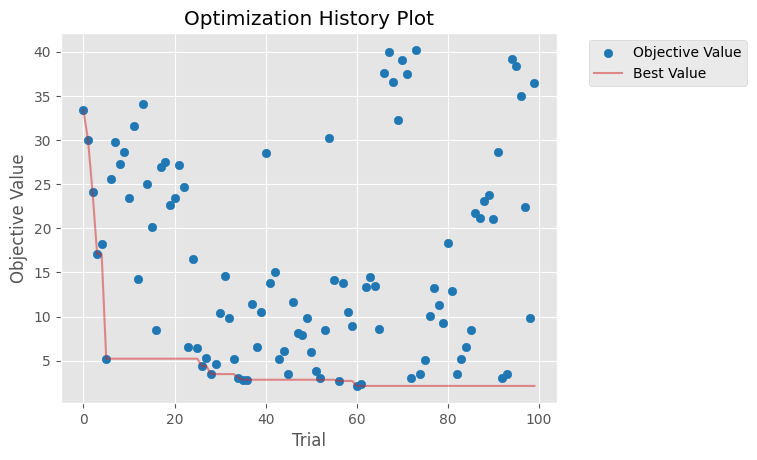

In [8]:
calib.plot_optuna('plot_optimization_history'); # Plot the optimization history

/Users/dklein/GIT/starsim/starsim/calibration.py:436: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)
[W 2025-04-04 10:35:46,138] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


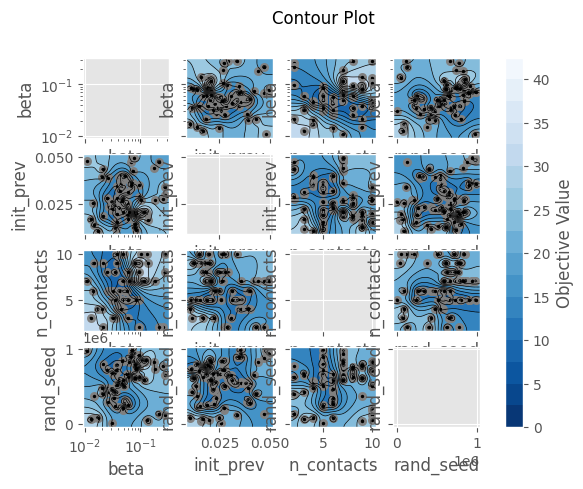

In [9]:
calib.plot_optuna('plot_contour');

/Users/dklein/GIT/starsim/starsim/calibration.py:436: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


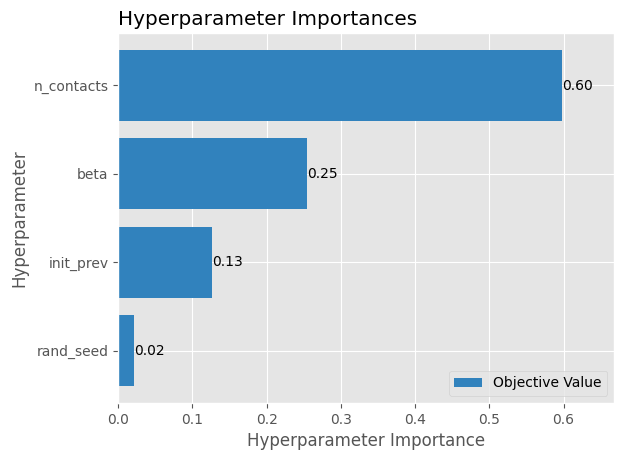

In [10]:
calib.plot_optuna('plot_param_importances');

## Checking that the calibration worked

Once the calibration is complete, we can compare the `guess` values to the best values found by calling `check_fit`. This function will return true if the best value identified by calibration yields a better fit than the guess value.

In [11]:
# Increase replicates to 15 for more representative results when running check_fit
calib.build_kw['n_reps'] = 15

improved = calib.check_fit(do_plot=False);

if improved:
    sc.printgreen('Fit improved!')
else:
    sc.printred('Fit did not improve!')



Checking fit...


Exception ignored in: <_io.BytesIO object at 0x160b834c0>
Traceback (most recent call last):
  File "/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/sciris/sc_utils.py", line 1243, in tolist
    default_coerce = (range, map, type({}.keys()), type({}.values()), type({}.items()))
BufferError: Existing exports of data: object cannot be re-sized
Exception ignored in: <_io.BytesIO object at 0x160b4b420>
Traceback (most recent call last):
  File "/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/sciris/sc_utils.py", line 1243, in tolist
    default_coerce = (range, map, type({}.keys()), type({}.values()), type({}.items()))
BufferError: Existing exports of data: object cannot be re-sized
Exception ignored in: <_io.BytesIO object at 0x162aec590>
Traceback (most recent call last):
  File "/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/sciris/sc_odict.py", line 1205, in __setitem__
    def __setitem__(self, name, value):
BufferError: Existing exports of data

Elapsed time: 0.502 s
Fit with original pars: 20.605838738040635
Fit with best-fit pars: 2.343614081088904
✓ Calibration improved fit 20.605838738040635 --> 2.343614081088904
Fit improved!


### Plotting timeseries
We can view some plots of the final fitted results. Whereas the two plots above were from the `check_fit`, running both "guess" and "best" parameters, here we make make new simulations to visualize the results.

Elapsed time: 1.27 s


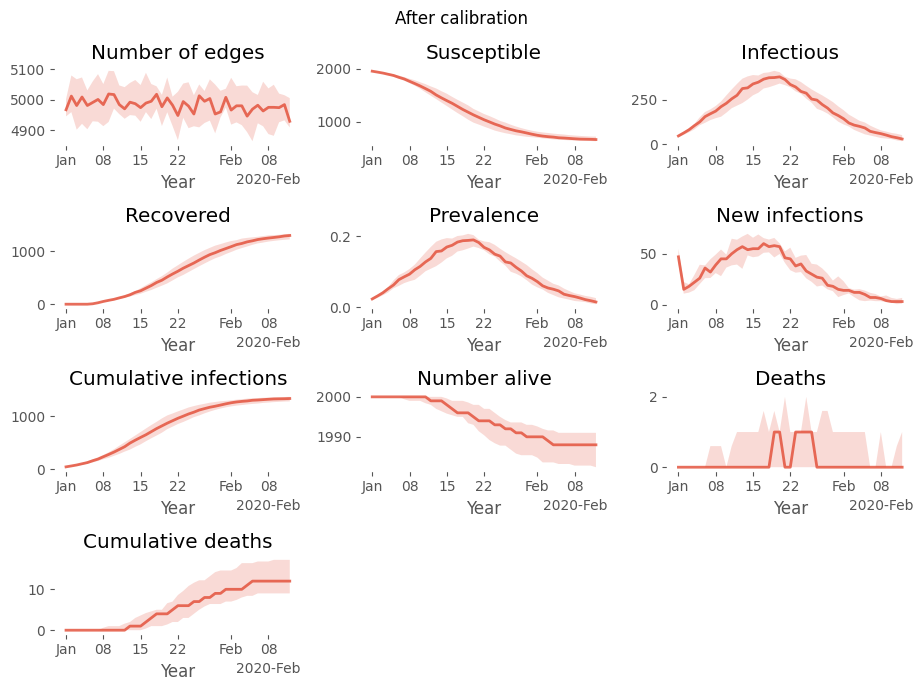

In [12]:
g = calib.plot_final(); # Run the model for build_kw['n_reps'] = 15 replicates
for ax in g.axes: # Fix the date formatting
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

### Plotting components

After calling `check_fit`, we can plot the individual CalibComponents using `calib.plot()`. This function is only useful if you have used the `CalibComponent` system, as it will not work with a custom `eval_fn`. The function will create a series of plots, one for each component, showing the likelihood of the observed data given the simulated data. Columns correspond to distinct time points and rows correspond to the different parameter configurations with the guess values shown on top and the best values identified by calibration shown on the bottom. If your data has additional covariates, like age, each covariate will be displayed on a separate figure.

There are two forms of the plot that can be generated. The first version, generated by default or by passing `bootstrap=False`, shows the likelihood of the observed data given the simulated data for each component. You will see one likelihood distribution for each replicate. The vertical dashed line is located at the true (observed) data. A black "X" for each replicate is placed at the likelihood of the observed data given the simulation result, illustrating the likelihood calculation. The higher the black "X" values, the better the fit.

Exception ignored in: <_io.BytesIO object at 0x160b868e0>
Traceback (most recent call last):
  File "/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/pandas/core/indexes/base.py", line 3809, in <genexpr>
    and any(isinstance(x, slice) for x in casted_key)
BufferError: Existing exports of data: object cannot be re-sized
/Users/dklein/GIT/starsim/starsim/calib_components.py:335: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  kk = np.arange(0, int(2*e_x))
/Users/dklein/GIT/starsim/starsim/calib_components.py:344: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(float(e_x), color='k', linestyle='--')
/Users/dklein/GIT/starsim/starsim/calib_components.py:335: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser

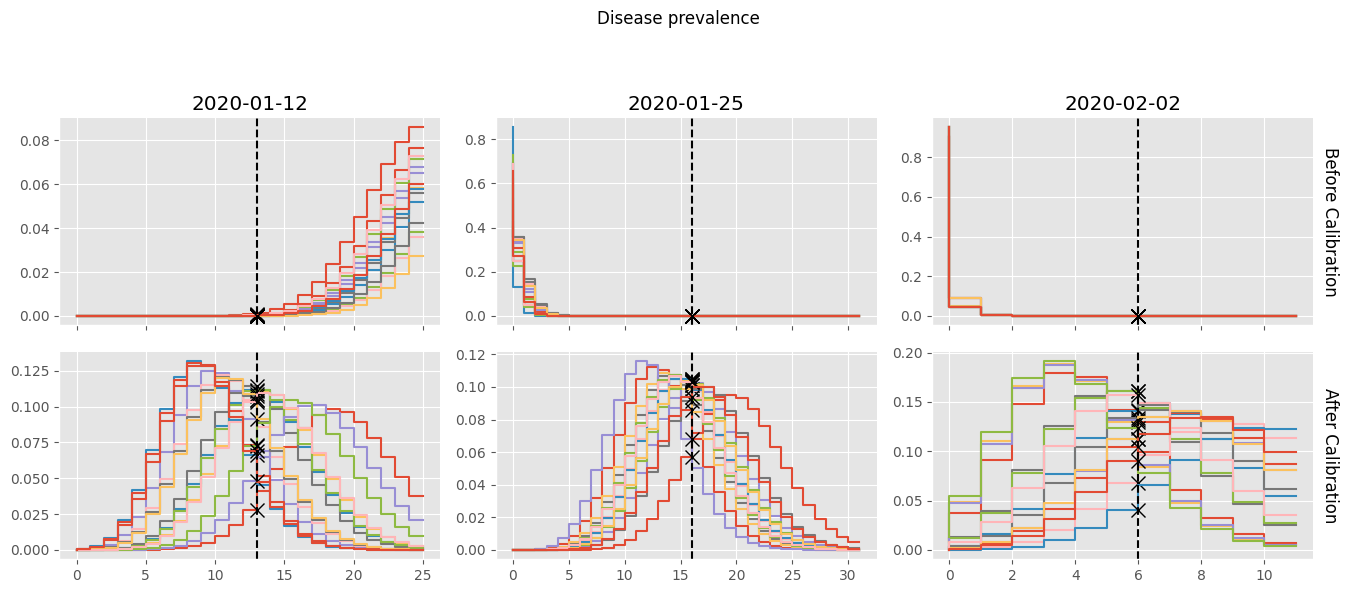

In [13]:
calib.plot();

The other way to plot the results is via bootstrapping, for calibrations in which multiple replicates are used per parameter set (trial). For the current example, passing `n_reps=15` to the `build_sim` function results in a MultiSim with 15 replicates.
The `bootstrap=True` option will construct a plot that shows the distribution of means.

The way bootstrapping works is to randomly select `n_reps` simulations from the `n_reps` simulations (with replacement), compute the likelihood for each replicate, and finally compute the mean of this collection of replicates. This process is repeated many times, saving the mean of the randomly selected replicates each time. Individual means are plotted as a "rug" and a kernel density function is shown. Ideally, one would like to see the distribution of means cetered around the true value (the vertical dashed line). The simulations are too high if the distribution is shifted to the right and too low if the distribution is shifted to the left.

<div class="alert alert-info">
The number of bootstrap samples is controlled by the `n_boot` argument. The default is 1000, but this can be changed to any number. The more samples, the better the estimate of the distributino of means. However, increasing the number of bootstraps will also increase the time it takes to generate the plot.
</div>

/Users/dklein/GIT/starsim/starsim/calib_components.py:372: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvline(float(e_x), color='k', linestyle='--')
/Users/dklein/GIT/starsim/starsim/calib_components.py:372: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvline(float(e_x), color='k', linestyle='--')
/Users/dklein/GIT/starsim/starsim/calib_components.py:372: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvline(float(e_x), color='k', linestyle='--')
/Users/dklein/GIT/starsim/starsim/calib_components.py:372: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvline(float(e_x), color='k', 

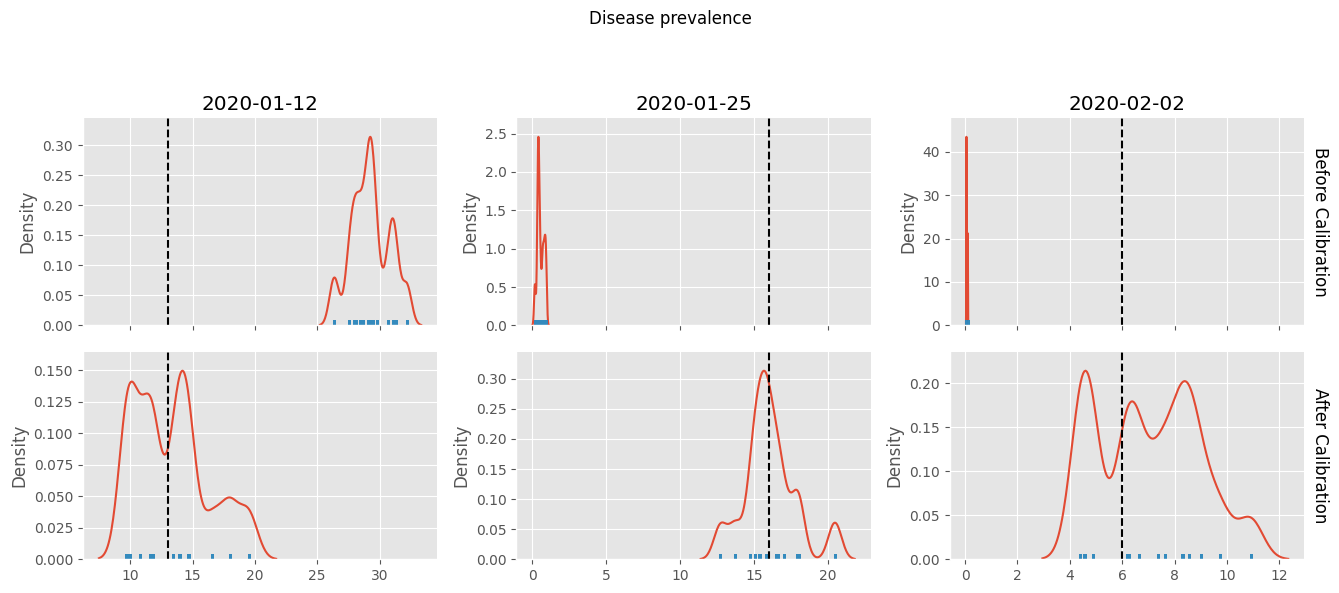

In [14]:
calib.plot(bootstrap=True); # Pass bootstrap=True to produce this plot

# Custom mismatch function

As mentioned previously, use of calibration components is optional. You can always create your own mismatch function, as in the following example:

In [15]:
my_data = (ss.date('2020-01-12'), 0.13)

def eval(sim, expected):
    # Compute the squared error at one point in time.
    # expected will contain my_data in this example due to eval_kw
    date, p = expected
    if not isinstance(sim, ss.MultiSim):
        sim = ss.MultiSim(sims=[sim])

    ret = 0
    for s in sim.sims:
        ind = np.searchsorted(s.results.timevec, date, side='left')
        prev = s.results.sir.prevalence[ind]
        ret += (prev - p)**2
    return ret


# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True),
)

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=2), # Two reps per point
    reseed = True,
    eval_fn = eval, # Will call my_function(msim, eval_kwargs)
    eval_kw = dict(expected=my_data), # Will call eval(sim, **eval_kw)
    total_trials = 10,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug,
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate()

# Check
calib.check_fit()

[I 2025-04-04 10:36:16,926] A new study created in RDB with name: starsim_calibration



Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db
Elapsed time: 0.181 s
Elapsed time: 0.185 s
Elapsed time: 0.179 s
Elapsed time: 0.185 s

[I 2025-04-04 10:36:17,304] Trial 5 finished with value: 0.3409871900112851 and parameters: {'beta': 0.14102684073072935, 'rand_seed': 6080}. Best is trial 5 with value: 0.3409871900112851.


Elapsed time: 0.196 s

[I 2025-04-04 10:36:17,304] Trial 3 finished with value: 0.5539083116791347 and parameters: {'beta': 0.20910931824310663, 'rand_seed': 922139}. Best is trial 5 with value: 0.3409871900112851.


[I 2025-04-04 10:36:17,317] Trial 0 finished with value: 0.033154249999999996 and parameters: {'beta': 0.011036572076549376, 'rand_seed': 724330}. Best is trial 2 with value: 0.03025974741985095.
[I 2025-04-04 10:36:17,320] Trial 2 finished with value: 0.03025974741985095 and parameters: {'beta': 0.020275274695453253, 'rand_seed': 128030}. Best is trial 6 with value: 0.0006195428379522425.
[I 2025-04-04 10:36:17,322] Trial 6 finished with value: 0.0006195428379522425 and parameters: {'beta': 0.07151826952378429, 'rand_seed': 150214}. Best is trial 6 with value: 0.0006195428379522425.


Elapsed time: 0.186 sElapsed time: 0.204 s



[I 2025-04-04 10:36:17,342] Trial 4 finished with value: 0.26866213601122296 and parameters: {'beta': 0.2736581229365388, 'rand_seed': 639813}. Best is trial 6 with value: 0.0006195428379522425.
[I 2025-04-04 10:36:17,342] Trial 7 finished with value: 0.5498953916313276 and parameters: {'beta': 0.18390040084749382, 'rand_seed': 665399}. Best is trial 6 with value: 0.0006195428379522425.


Elapsed time: 0.185 s
Elapsed time: 0.184 s

[I 2025-04-04 10:36:17,362] Trial 1 finished with value: 0.031013 and parameters: {'beta': 0.018230219184270837, 'rand_seed': 534662}. Best is trial 6 with value: 0.0006195428379522425.


[I 2025-04-04 10:36:17,373] Trial 8 finished with value: 0.026449477915253594 and parameters: {'beta': 0.024421153566923016, 'rand_seed': 620163}. Best is trial 6 with value: 0.0006195428379522425.


Elapsed time: 0.176 s


[I 2025-04-04 10:36:17,399] Trial 9 finished with value: 0.012396816603677648 and parameters: {'beta': 0.05217222359544449, 'rand_seed': 302073}. Best is trial 6 with value: 0.0006195428379522425.


Making results structure...
Processed 10 trials; 0 failed
Best pars: {'beta': 0.07151826952378429, 'rand_seed': 150214}
Removed existing calibration file starsim_calibration.db

Checking fit...


Exception ignored in: <_io.BytesIO object at 0x165a75fd0>
Traceback (most recent call last):
  File "/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/sciris/sc_utils.py", line 1104, in isstring
    def isstring(obj):
BufferError: Existing exports of data: object cannot be re-sized
Exception ignored in: <_io.BytesIO object at 0x165e571f0>
Traceback (most recent call last):
  File "/Users/dklein/GIT/starsim/.venv/lib/python3.13/site-packages/sciris/sc_utils.py", line 1104, in isstring
    def isstring(obj):
BufferError: Existing exports of data: object cannot be re-sized


Elapsed time: 0.173 s
Fit with original pars: 0.38227206020661
Fit with best-fit pars: 0.0032075845399790154
✓ Calibration improved fit 0.38227206020661 --> 0.0032075845399790154


True

## Additional features of the Calibration class

The `Calibration` class has a few additional features that are worth mentioning. These include:

### Extracting results

After calibration has completed, you can extract the results using either `.to_df()` or `.to_json()`. The result returned by `to_df()` will be sorted by "value", which is the overall mismatch score (lower is better). You'll also be able to see all of the parameters selected by Optuna in columns named "param_x", where x is the name of the parameter. Pass in `top_k` to return only the best k results. The result can easily be saved to disk using Pandas `.to_csv()` method.

The `to_json()` method will return a JSON object that can be easily saved as well.

In [16]:
dataframe = calib.to_df(top_k=5) # Get the top 5 parameter sets
display(dataframe)

,value,datetime_start,datetime_complete,duration,params_beta,params_rand_seed,state
number,,,,,,,
6,0.000620,2025-04-04 10:36:17.057340,2025-04-04 10:36:17.316040,0 days 00:00:00.258700,0.071518,150214,COMPLETE
9,0.012397,2025-04-04 10:36:17.074770,2025-04-04 10:36:17.392838,0 days 00:00:00.318068,0.052172,302073,COMPLETE
8,0.026449,2025-04-04 10:36:17.045331,2025-04-04 10:36:17.367941,0 days 00:00:00.322610,0.024421,620163,COMPLETE
2,0.030260,2025-04-04 10:36:17.028381,2025-04-04 10:36:17.311801,0 days 00:00:00.283420,0.020275,128030,COMPLETE
1,0.031013,2025-04-04 10:36:17.025808,2025-04-04 10:36:17.356344,0 days 00:00:00.330536,0.018230,534662,COMPLETE


In [17]:
output = calib.to_json() # Get the output as a list of dictionaries
print(output[0]) # Print the first entry

{'index': 6.0, 'mismatch': 0.0006195428379522425, 'pars': {'beta': 0.07151826952378429, 'rand_seed': 150214.0}}


### Callback functions

The CSV and JSON outputs contain only the mismatch values, corresponding parameters, and one metadata. To obtain more information from each trial, you can use callback functions. These functions are called after each trial and can be used to extract additional information from the simulation. The callback function should take two arguments, `study` and `trial`, and can be used to extract any information from the simulation that you want to save. Callbacks can be used to save information from every trial, print a message when a new best trial is found, or even terminate the optimization if sufficient progress has been made.  Any callback functions you would like to use should be passed to the `callbacks` argument of the `Calibration` class.

Here's an example callback that works with the calibration components to save the "actual" dataframe extracted from each simulation.

<div class="alert alert-danger" role="alert">
Note that data cannot be saved in the callback function itself! This is due to the fact that each parallel worker creates a separate instance of the callback. These workers terminate at the end of calibration, and thus any data they may have accumulated will be lost. For this reason, the `SaveResults` example below saves data directly to disk. This simple solution works, but consider using a database.
</div>

```python
class SaveResults:
    def __init__(self, components, resdir):
        self.comps = components
        self.resdir = resdir
        return

    def __call__(self, study, trial):
        for comp in self.comps:
            actual = comp.actual
            actual["trial"] = trial.number
            actual["nll"] = comp.nll

            file_path = os.path.join(self.resdir, f"tmp_{comp.name}_{trial.number}.csv")
            actual.to_csv(file_path)
        return

save_callback = SaveResults(components, resdir)

calib = ss.Calibration(
    ...
    callbacks=[save_callback]
)
```

### Parameter constraints

The `Calibration` class also allows you to implement constraints on the calibration parameters. Range constraints for each individual parameter are handled by the parameter definition, recall that each parameter has a `low` and `high` value. However, you can also implement constraints that involve multiple parameters. For example, you might want to ensure that the sum of two parameters is less than a certain value or that one parameter is less than another.

To do this, you can use the `prune_fn` argument of the `Calibration` class. This argument should be a callable function that takes in the current parameter values and returns a boolean value indicating whether the parameters are valid or not. If the function returns `True`, the optimization algorithm will skip that trial and move on to the next one. Here is an example pruning function:

```python
def prune_fn(pars):
    if 'x1' in pars and 'x2' in pars:
        # Prune if x1 is greater than x2
        return pars['x1']['value'] > pars['x2']['value']
    return False

# Make the calibration
calib = ss.Calibration(
    ...
    prune_fn = prune_fn
)
```

### Reseeding

By default, the `Calibration` class will choose random random number seeds for each trial. If you want to use the same random seed for each trial, you can set the `reseed` argument to `False`. If reseeding, the calibration will add a parameter named `rand_seed` to the dictionary of parameters passed to the `build_sim` function. It's up to you to use this parameter in the simulation(s) that are returned by the `build_sim` function. If your simulation builder creates multiple realizations/replicates per trial, you could increment from the `rand_seed` value. For example, if `rand_seed=1234` and you have 5 replicates, you could set the random seed for each replicate to `1234 + i`, where `i` is the index of the replicate. The example `build_sim` function at the top of this tutorial demonstrates this approach.

## Additional features specific to the `CalibComponent` system

The following features increase the capabilities of calibrations that make use of the `CalibComponent` system.

### Grouped data

If you calibration targets have additional structure, for example results are stratified by age, sex, or other feature, you do not have to create a separate component for each group. Instead, you can provide expected and extract_fn dataframes with a MultiIndex.

Typically, the "expected" (observed) target data has time as the only index. The data index would be just "t" if using the `step_containing` or `prevalent` conformers, or "t" and "t1" if using the `incident` conformer. Additional data groupings can be handled by including additional index columns. For example if data and simulation results are stratified into "LOW" and "HIGH" socio-economic (SES) groups, a BetaBinomial component could be defined as follows:

```python
num_infectious = ss.BetaBinomial(
    name = 'Number Infectious',
    conform = 'prevalent',

    expected = pd.DataFrame({
        'n': [140, 137, 60, 59], # Number of individuals sampled
        'x': [21, 23, 9, 11],    # Number of individuals found to be infectious
        't': [ss.date(d) for d in ['2020-01-12', '2020-01-25', '2020-01-12', '2020-01-25']], # On these dates
        'ses': ['LOW', 'LOW', 'HIGH', 'HIGH'], # By SES
    }).set_index(['t', 'ses']), # Create a MultiIndex with time and SES

    extract_fn = lambda sim: pd.DataFrame({
        'x': np.concatenate((sim.results.byses.n_infected_LOW, sim.results.byses.n_infected_HIGH)),
        'n': np.concatenate((sim.results.byses.n_alive_LOW, sim.results.byses.n_alive_HIGH)),
    }, index=pd.MultiIndex.from_product([SES.keys(), sim.results.timevec], names=['ses', 't'])), # Put time and SES in the index
)
```

### Combining realizations

If the build_sim function is configured to return a MultiSim object containing multiple realizations, you can control how those realizations feed into the likelihood calculations. By default, a separate likelihood number is calculated for each replicate, and these values are combined (summed in negative log space). However, you can also combine the data extracted from each simulation _prior_ to calculating the likelihood. For example, you can sum realizations, compute the mean over realizations, or apply some other function of your choice.

One application where combining replicates is useful is if the individual realizations created by `build_sim` represent distinct communities. The sum of infections across all communities is what we want to calibrate, not each individual community. So here it would be appropriate to apply a sum. A sum would not be appropriate for prevalence data, but a mean might be appropriate.

Combining multiple realizations (e.g. replicates) of a single parameter trial is accomplished at the component level via the `combine_reps` argument. You can pass in a string, like "mean" or "sum", or a callable function that will be called by a Pandas `.aggregate` operation following selection of random seeds and grouping by time. Any keyword arguments to be passed to aggregate can be passed in via the `combine_kwargs` argument. Here is the code that combines replicates in the `CalibComponent` class:
```python
actual = data.set_index('rand_seed').loc[use_seeds].groupby('t').aggregate(func=self.combine_reps, **self.combine_kwargs)
```

When building your calibration component, you can specify the `combine_reps` argument as follows:
```python
component = ss.DirichletMultinomial(
    name = "Example combining multiple realizations prior to likelihood calcaulation",
    build_sim = build_sim,
    build_kw = dict(n_reps=15), # Ask build_sim to create 15 replicates
    combine_reps = 'mean', # or 'sum' or a callable function
    ...
)
```

### Bootstrapping

Again if your `build_sim` function is configured to return a MultiSim object containing multiple realizations, you can use bootstrapping in computing the likelihood. Bootstrapping is particularly useful in combination with the `combine_reps` argument. The idea is to randomly select a subset of the realizations (with replacement) and compute the likelihood based on this subset. This process is repeated many times, and the mean of bootstraps is returned as the final likelihood.

Bootstrapping is configured by setting the `n_boot` argument in the `CalibComponent` class. Bootstrapped likelihood calculation is not enabled by default, and only applies if each parameter trial has multiple realizations.
```python
component = ss.Normal(
    name = "Example bootstrap",
    n_boot = 1000, # Number of bootstrap samples
    ...
)
```

### Selecting specific simulations

When creating a calibration experiment in which each trial (parameter set selected by Optuna) is run multiple times, you can select a subset of simulations to use for the evaluation. This set could be used to remove simulations that burned out or had other issues. Also, if building a more complex experiment, for example containing "control" and "intervention" arms, you may want to select only one arm for use in a calibration component.

Such filtering is accomplished using the `include_fn` argument of the `CalibComponent`. This function should take in a simulation and return a boolean value indicating whether the simulation should be included or not. Here is an example:

```python
    prevalence_intv = ss.Binomial(
        name = 'Prevalence Active (Intervention)',

        # Include only simulations for which the label is "Intervention"
        # and there is at least one infected person after 2013-01-01
        include_fn = lambda sim: sim.label == 'Intervention' and np.any(sim.results.tb.n_infected[sim.timevec >= ss.date('2013-01-01')] > 0),
        ...
    )
```

Note that with this approach, it is possible that all simulations are excluded for a given trial. In this case, the trial will be given a mismatch of `np.inf` and will be skipped by the optimization algorithm.

# Conclusion

The calibration framework built into Starsim provides a powerful and flexible way to calibrate models using optimization algorithms. The built-in components make it easy to use common likelihood functions, while the ability to create custom components and evaluation functions allows for maximum flexibility. Good luck, may all your calibrations be successful!

For more, take a look at [test_calibration.py](../../tests/test_calibration.py) in the tests directory.